<a href="https://colab.research.google.com/github/ankur-1232/Google-Colab-Notebooks/blob/main/Statistical_Quality_%26_Reliability_Analysis_of_Storage_Hardware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*To analyze real-world failure data of consumer storage hardware and apply statistical quality and reliability methods to identify high-risk models, quantify failure behavior, and support data-driven quality decisions.*

### **Scope boundaries**
* Focus is on failure behavior and quality metrics
* No claims about hardware design or materials
* Analysis is post-deployment, not manufacturing-stage








## **Section 0**
### Dataset Understanding & Ingestion
**Backblaze Dataset**

* Daily snapshots of deployed hard drives
* Drive identifiers
* Model namesw
* Capacity
* SMART indicatorsw
* Failure flag (binary)
* Date


## **Section 1**
### Imports & Environmental Setup

In [ ]:
pip install reliability

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Reliability & statistics
from reliability.Distributions import Weibull_Distribution, Exponential_Distribution
from reliability.Fitters import Fit_Weibull_2P, Fit_Exponential_1P

import scipy.stats as stats

In [ ]:
import seaborn as sns

sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)

plt.rcParams.update({
    "figure.dpi": 100,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 12,
    "grid.alpha": 0.4,
    "grid.linestyle": "--"
})


In [ ]:
import zipfile
import os

zip_path = "/content/data_Q3_2025.zip"
extract_path = "/content/backblaze_q3_2025"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

len(os.listdir(extract_path))

1

In [ ]:
os.listdir(extract_path)

['data_Q3_2025']

In [ ]:
import glob
csv_files = glob.glob(f"{extract_path}/**/*.csv", recursive=True)
len(csv_files)

92

In [ ]:
sample_file = csv_files[0]
pd.read_csv(sample_file, nrows=5)

,date,serial_number,model,capacity_bytes,...,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2025-08-07,2207E60CC65A,CT250MX500SSD1,250059350016,...,NaN,NaN,NaN,NaN
1,2025-08-07,2340E87B92B5,CT250MX500SSD1,250059350016,...,NaN,NaN,NaN,NaN
2,2025-08-07,2340E87B97E8,CT250MX500SSD1,250059350016,...,NaN,NaN,NaN,NaN
3,2025-08-07,2EGK64VX,HGST HUH728080ALE604,8001563222016,...,NaN,NaN,NaN,NaN
4,2025-08-07,2EHZAKAX,HGST HUH728080ALE604,8001563222016,...,NaN,NaN,NaN,NaN


In [ ]:
use_cols = [
    "date",
    "serial_number",
    "model",
    "capacity_bytes",
    "failure",
    "datacenter",
    "cluster_id"
]

dfs = []

for file in csv_files:
    df_daily = pd.read_csv(file, usecols=use_cols)
    dfs.append(df_daily)

df = pd.concat(dfs, ignore_index=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29844451 entries, 0 to 29844450
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   date            object
 1   serial_number   object
 2   model           object
 3   capacity_bytes  int64 
 4   failure         int64 
 5   datacenter      object
 6   cluster_id      int64 
dtypes: int64(3), object(4)
memory usage: 1.6+ GB


In [ ]:
df.head()

,date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id
0,2025-08-07,2207E60CC65A,CT250MX500SSD1,250059350016,0,sac0,0
1,2025-08-07,2340E87B92B5,CT250MX500SSD1,250059350016,0,sac0,0
2,2025-08-07,2340E87B97E8,CT250MX500SSD1,250059350016,0,sac0,0
3,2025-08-07,2EGK64VX,HGST HUH728080ALE604,8001563222016,0,sac0,0
4,2025-08-07,2EHZAKAX,HGST HUH728080ALE604,8001563222016,0,sac0,0


In [ ]:
print("Total rows:", len(df))
print("Unique drives:", df["serial_number"].nunique())
print("Unique models:", df["model"].nunique())

Total rows: 29844451
Unique drives: 332915
Unique models: 77


In [ ]:
df["failure"].value_counts()

,count
failure,
0,29843197
1,1254


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by=["serial_number", "date"])

## **Section 2**
### Failure Labeling, Time-in-Service & Censoring


In [ ]:
observation_start = df["date"].min()
observation_end = df["date"].max()
print("Observation period:", observation_start, "to", observation_end)

Observation period: 2025-07-01 00:00:00 to 2025-09-30 00:00:00


In [ ]:
failures = df[df["failure"] == 1]
first_failure = (
    failures
    .groupby("serial_number")["date"]
    .min()
    .reset_index()
    .rename(columns={"date": "failure_date"})
)

first_failure.head()

,serial_number,failure_date
0,1050A02WF9RG,2025-09-10
1,1060A00RF97G,2025-09-18
2,1060A02MF97G,2025-08-29
3,1070A05AF97G,2025-09-16
4,1070A0CGF97G,2025-07-25


In [ ]:
start_dates = (
    df
    .groupby("serial_number")["date"]
    .min()
    .reset_index()
    .rename(columns={"date": "start_date"})
)

start_dates.head()

,serial_number,start_date
0,000a43e7dee60010,2025-07-01
1,00ac486b9bec0010,2025-07-01
2,01b776caeb6a0010,2025-07-01
3,02308a3415be0010,2025-07-01
4,0394cd7bc5d00010,2025-07-01


In [ ]:
lifecycle = start_dates.merge(
    first_failure,
    on="serial_number",
    how="left"
)

lifecycle.head()

,serial_number,start_date,failure_date
0,000a43e7dee60010,2025-07-01,NaT
1,00ac486b9bec0010,2025-07-01,NaT
2,01b776caeb6a0010,2025-07-01,NaT
3,02308a3415be0010,2025-07-01,NaT
4,0394cd7bc5d00010,2025-07-01,NaT


In [ ]:
lifecycle["event_observed"] = lifecycle["failure_date"].notna().astype(int)
lifecycle["event_observed"].value_counts()

,count
event_observed,
0,331661
1,1254


In [ ]:
lifecycle["end_date"] = lifecycle["failure_date"].fillna(observation_end)

In [ ]:
lifecycle["time_in_service_days"] = (lifecycle["end_date"] - lifecycle["start_date"]).dt.days

In [ ]:
lifecycle["time_in_service_days"].describe()

,time_in_service_days
count,332915
mean,88.8672
std,11.9652
min,0
25%,91
50%,91
75%,91
max,91


In [ ]:
model_map = (
    df
    .groupby("serial_number")["model"]
    .first()
    .reset_index()
)

lifecycle = lifecycle.merge(model_map, on="serial_number", how="left")

lifecycle.head()

,serial_number,start_date,failure_date,event_observed,end_date,time_in_service_days,model
0,000a43e7dee60010,2025-07-01,NaT,0,2025-09-30,91,DELLBOSS VD
1,00ac486b9bec0010,2025-07-01,NaT,0,2025-09-30,91,DELLBOSS VD
2,01b776caeb6a0010,2025-07-01,NaT,0,2025-09-30,91,DELLBOSS VD
3,02308a3415be0010,2025-07-01,NaT,0,2025-09-30,91,DELLBOSS VD
4,0394cd7bc5d00010,2025-07-01,NaT,0,2025-09-30,91,DELLBOSS VD


In [ ]:
### Sanity Checks

# Failed drives must have event_observed = 1
assert lifecycle.loc[lifecycle["event_observed"] == 1, "failure_date"].notna().all()

#Censored drives must have failure_date = NaN
assert lifecycle.loc[lifecycle["event_observed"] == 0, "failure_date"].isna().all()

#Exposure time must be non-negative
assert (lifecycle["time_in_service_days"] >= 0).all()

**Failure & Censoring Summary**

* Each drive is treated as a single unit with a defined exposure period.

* Failure is modeled as a terminal event occurring at the first observed failure date.

* Drives without observed failure are treated as right-censored at the end of the observation window.

* Time-in-service is computed as the difference between exposure start and end dates.

## **Section 3**
### Exploratory Quality Analysis


In [ ]:
total_drives = lifecycle.shape[0]
failed_drives = lifecycle["event_observed"].sum()

failure_rate = failed_drives / total_drives

total_drives, failed_drives, failure_rate

(332915, np.int64(1254), np.float64(0.0037667272426895756))

In [ ]:
model_summary = (
    lifecycle
    .groupby("model")
    .agg(
        total_units=("serial_number", "count"),
        failed_units=("event_observed", "sum"),
        avg_exposure_days=("time_in_service_days", "mean")
    )
    .reset_index()
)

model_summary["failure_rate"] = (
    model_summary["failed_units"] / model_summary["total_units"]
)

model_summary.sort_values("failure_rate", ascending=False).head(10)

,model,total_units,failed_units,avg_exposure_days,failure_rate
24,ST12000NM0117,7,1,88.7143,0.142857
61,TOSHIBA MG08ACA16TEY,5145,215,89.1275,0.0417881
26,ST14000NM0018,64,2,89.1875,0.03125
17,ST10000NM0086,1018,20,89.9715,0.0196464
29,ST14000NM0138,1286,22,90.2449,0.0171073
19,ST12000NM0007,1005,13,90.5861,0.0129353
7,HGST HUH721212ALN604,9985,109,90.5802,0.0109164
25,ST14000NM000J,392,4,80.4643,0.0102041
31,ST16000NM000J,112,1,69.2589,0.00892857
58,TOSHIBA MG07ACA14TEY,970,8,87.2969,0.00824742


In [ ]:
failure_contrib = (
    model_summary
    .sort_values("failed_units", ascending=False)
)

failure_contrib["cumulative_failures"] = failure_contrib["failed_units"].cumsum()
failure_contrib["cumulative_percent"] = (
    failure_contrib["cumulative_failures"] / failed_drives
)

failure_contrib.head(10)

,model,total_units,failed_units,avg_exposure_days,failure_rate,cumulative_failures,cumulative_percent
61,TOSHIBA MG08ACA16TEY,5145,215,89.1275,0.0417881,215,0.171451
20,ST12000NM0008,18902,132,90.7055,0.00698339,347,0.276715
57,TOSHIBA MG07ACA14TA,37463,116,90.8566,0.00309639,463,0.369219
7,HGST HUH721212ALN604,9985,109,90.5802,0.0109164,572,0.45614
59,TOSHIBA MG08ACA16TA,40184,85,90.8526,0.00211527,657,0.523923
6,HGST HUH721212ALE604,13417,65,90.5535,0.0048446,722,0.575758
74,WDC WUH721816ALE6L4,26414,64,90.8228,0.00242296,786,0.626794
32,ST16000NM001G,34128,57,90.5837,0.00167018,843,0.672249
43,ST8000NM0055,13351,53,90.8262,0.00396974,896,0.714514
75,WDC WUH722222ALE6L4,40271,50,88.5025,0.00124159,946,0.754386


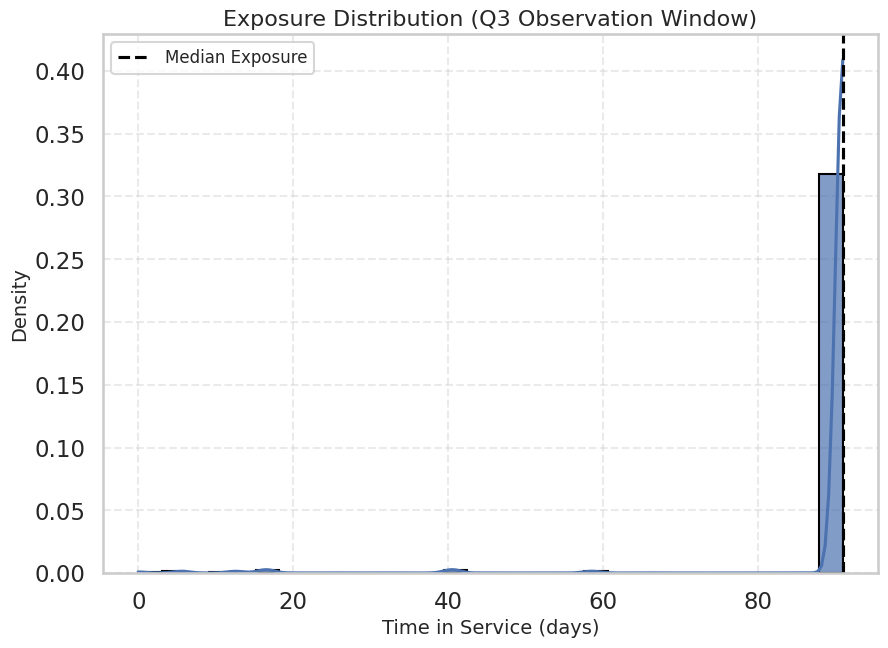

In [ ]:
plt.figure(figsize=(10,7))

sns.histplot(
    lifecycle["time_in_service_days"],
    bins=30,
    kde=True,
    stat="density",
    edgecolor="black",
    alpha=0.7
)

plt.axvline(
    lifecycle["time_in_service_days"].median(),
    color="black",
    linestyle="--",
    label="Median Exposure"
)

plt.xlabel("Time in Service (days)")
plt.ylabel("Density")
plt.title("Exposure Distribution (Q3 Observation Window)")
plt.legend()
plt.show()


In [ ]:
lifecycle.groupby("event_observed")["time_in_service_days"].describe()

,count,mean,std,min,25%,50%,75%,max
event_observed,,,,,,,,
0,331661,89.0215,11.6064,0,91,91,91,91
1,1254,48.0542,26.6239,0,26,48,72,91


**Exploratory Quality Findings**

* The dataset represents a fixed quarterly observation window with heavy right-censoring.

* Failure events are rare relative to deployed population.

* Certain drive models contribute disproportionately to observed failures.

* Most failures occur before the end of the observation window, suggesting early-life or random failure behavior.

## **Section 4**
### Reliability Modeling
*We are modeling time-to-failure with right-censored data under a fixed observation window, so reliability estimates describe early-life behavior, not full lifecycle durability.*

### Prepare Data for Reliability Library

In [ ]:
failures = lifecycle.loc[lifecycle["event_observed"] == 1, "time_in_service_days"].values
right_censored = lifecycle.loc[lifecycle["event_observed"] == 0, "time_in_service_days"].values

len(failures), len(right_censored)

(1254, 331661)

In [ ]:
from reliability.Fitters import Fit_Exponential_1P

exp_fit = Fit_Exponential_1P(
    failures=failures,
    right_censored=right_censored,
    show_probability_plot=False
)


Results from Fit_Exponential_1P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 1235/331009 (99.62829% right censored) 

Parameter  Point Estimate  Standard Error    Lower CI    Upper CI
   Lambda     0.000100544     2.86103e-06 9.50898e-05 0.000106311
 1/Lambda         9945.91         283.016     9406.39     10516.4 

Goodness of fit    Value
 Log-likelihood -14342.7
           AICc  28687.4
            BIC  28698.1
             AD  6975.51 



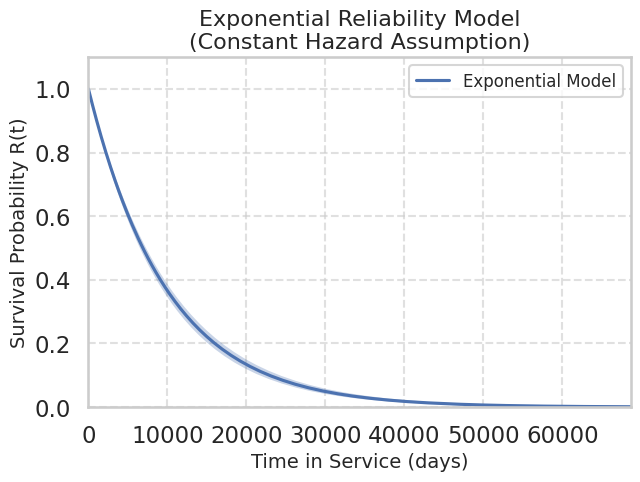

In [ ]:
plt.figure(figsize=(7,5))
exp_fit.distribution.SF(label="Exponential Model")

plt.title("Exponential Reliability Model\n(Constant Hazard Assumption)")
plt.xlabel("Time in Service (days)")
plt.ylabel("Survival Probability R(t)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


In [ ]:
from reliability.Fitters import Fit_Weibull_2P

wb_fit = Fit_Weibull_2P(
    failures=failures,
    right_censored=right_censored,
    show_probability_plot=False
)


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1235/331009 (99.62829% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         11013.4         1520.24   8402.82     14435
     Beta         1.16174       0.0328518    1.0991   1.22794 

Goodness of fit    Value
 Log-likelihood -13675.3
           AICc  27354.6
            BIC  27376.1
             AD  7320.89 



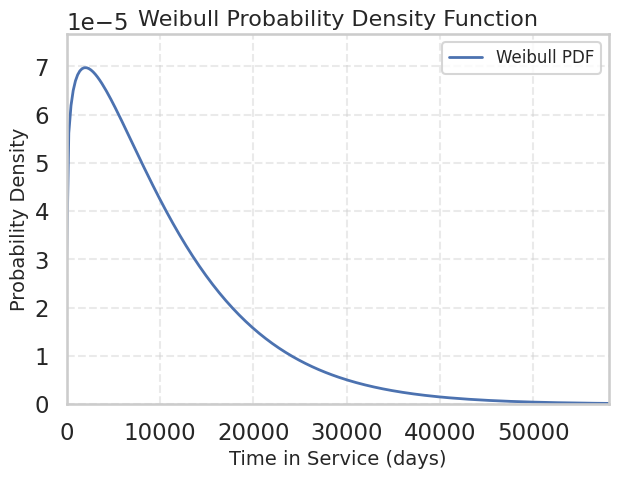

In [ ]:
plt.figure(figsize=(7,5))
wb_fit.distribution.PDF(label="Weibull PDF", linewidth=2)
plt.xlabel("Time in Service (days)")
plt.ylabel("Probability Density")
plt.title("Weibull Probability Density Function")
plt.legend()
plt.show()


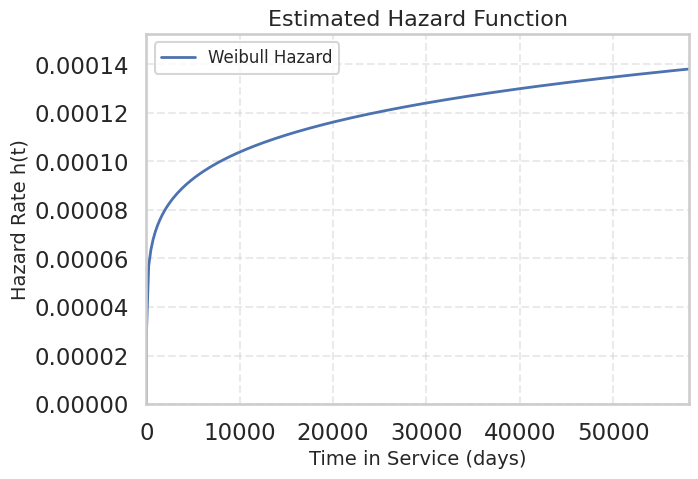

In [ ]:
plt.figure(figsize=(7,5))
wb_fit.distribution.HF(label="Weibull Hazard", linewidth=2)
plt.xlabel("Time in Service (days)")
plt.ylabel("Hazard Rate h(t)")
plt.title("Estimated Hazard Function")
plt.legend()
plt.show()


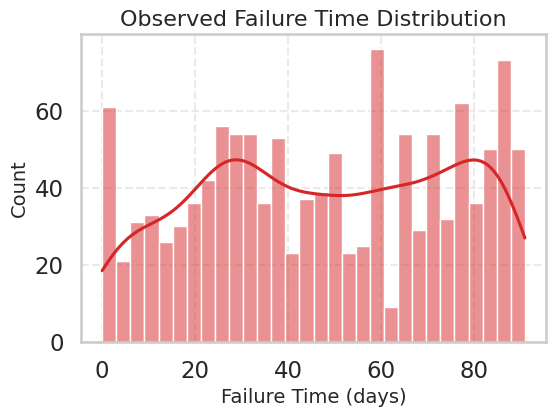

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(failures, bins=30, kde=True, color="tab:red")
plt.xlabel("Failure Time (days)")
plt.title("Observed Failure Time Distribution")
plt.show()


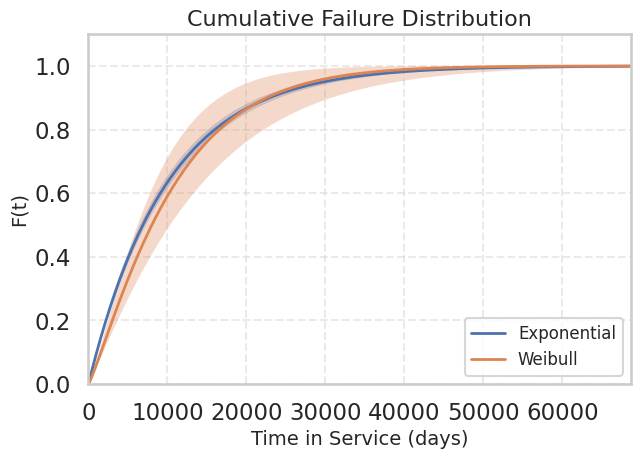

In [ ]:
plt.figure(figsize=(7,5))
exp_fit.distribution.CDF(label="Exponential", linewidth=2)
wb_fit.distribution.CDF(label="Weibull", linewidth=2)

plt.xlabel("Time in Service (days)")
plt.ylabel("F(t)")
plt.title("Cumulative Failure Distribution")
plt.legend()
plt.show()
